# Compare CI vs SI runs

This notebook makes manuscript plots comparing the CI vs. SI unstable runs.

1) Figure comparing lateral versus vertical shear production for the two runs.

2) Figure showing two panel vertical profiles of shear production, buoyancy production, and diss (with scaling for eps).


In [159]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [160]:
def EstimateBStress(f, visc):
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    S2 = N**2*tht**2/1e-8
    
    v = f['tasks']['v'] # Along-slope direction
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    vm = np.mean(v, axis=1)
    vz = np.gradient(vm, axis=-1)/np.gradient(z) 
    tauy = -1035*visc*vz[:,0] #Note that 1e-4 is the viscosity for the DNS

    # Calculate the Ekman transport using bottom stress:
    Beka = tauy/(1030*1e-4*(1+S2))*N**2*np.sin(tht)
    
    nt = Beka.shape[0]
    toff = 12
    Ho = 8
    Ent = 1.0 # Entrainment factor...
    H2 = np.zeros((nt, )) 
    for i in range(toff, nt):
        H2[i] = H2[i-1]+(2*(1+S2)*Ent*-Beka[i]/(N**2))*(time[i]-time[i-1])
    
    H = np.sqrt(Ho**2 + H2)
    H[0:toff] = np.nan
    
    return H, Beka, S2

In [169]:
#%% Pick the filename and path
CIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope
CIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5' #0.1 slope

SIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5' #Ruan case F

visc = 1e-4
Vi = 0.1

SAVEFLAG = False # Turn on to savefigs


f = h5py.File(CIfilename, 'r')
LATSP_CI = -f['tasks']['LSPv'][:,0,:] - f['tasks']['LSPu'][:,0,:]
VERTSP_CI = -f['tasks']['VSPv'][:,0,:] - f['tasks']['VSPu'][:,0,:]
SP_CI = -f['tasks']['SP'][:,0,:]
DISS_CI  = f['tasks']['Diss'][:,0,:]
VBP_CI = f['tasks']['VBFr'][:,0,:]

H_CI, BEK_CI, S2_CI = EstimateBStress(f, visc)
# Domain parameters
z_CI = f['tasks']['u'].dims[2][0][:]
time_CI = f['tasks']['u'].dims[0][0][:]

##### SI RUN  ########
f = h5py.File(SIfilename, 'r')
LATSP_SI = -f['tasks']['LSPv'][:,0,:] - f['tasks']['LSPu'][:,0,:]
VERTSP_SI = -f['tasks']['VSPv'][:,0,:] - f['tasks']['VSPu'][:,0,:]
SP_SI = -f['tasks']['SP'][:,0,:]
DISS_SI  = f['tasks']['Diss'][:,0,:]
VBP_SI = f['tasks']['VBFr'][:,0,:]

H_SI, BEK_SI, S2_SI = EstimateBStress(f, visc)

# Domain parameters
z_SI = f['tasks']['u'].dims[2][0][:]
time_SI = f['tasks']['u'].dims[0][0][:]



In [170]:
S2_CI

9.999999999999998

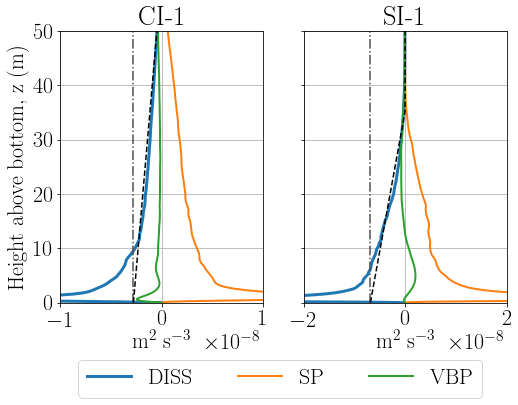

In [171]:
t1 = 4
t2 = 6
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,5))
ax[0].plot(np.mean(DISS_CI[ti_CI,:], axis=0), z_CI, linewidth=3)
ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VBP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].axvline(np.mean(BEK_CI[ti_CI]), color='0.3', linestyle='-.')
#ax[0].axhline(np.mean(H_CI[ti_CI]))
ax[0].grid()
PEPS = np.mean(BEK_CI[ti_CI])*(1-z_CI/np.mean(H_CI[ti_CI]))
PEPS[z_CI>np.mean(H_CI[ti_CI])] = 0
ax[0].plot(PEPS, z_CI, color='k', linestyle='--')
ax[0].set_ylim(0, 50)
ax[0].set_xlim(-1e-8, 1e-8)
ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')

### SI ####
l1 = ax[1].plot(np.mean(DISS_SI[ti_SI,:], axis=0), z_SI, linewidth=3, label='DISS')
l2 = ax[1].plot(np.mean(SP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP')
ax[1].plot(np.mean(VBP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='VBP')
ax[1].axvline(np.mean(BEK_SI[ti_SI]), color='0.3', linestyle='-.')
#ax[0].axhline(np.mean(H_CI[ti_CI]))
ax[1].grid()
PEPS = np.mean(BEK_SI[ti_SI])*(1-z_SI/np.mean(H_SI[ti_SI]))
PEPS[z_SI>np.mean(H_SI[ti_SI])] = 0
ax[1].plot(PEPS, z_SI, color='k', linestyle='--')
ax[1].set_xlim(-2e-8, 2e-8)
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')

ax[1].legend(bbox_to_anchor=(-0.115, -0.35), loc='lower center', borderaxespad=0., ncol=3)
ax[0].set_ylabel('Height above bottom, z (m)')

#SAVEFLAG = True
if SAVEFLAG:
    plt.savefig(f'./MSFigs/DISSProfiles.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

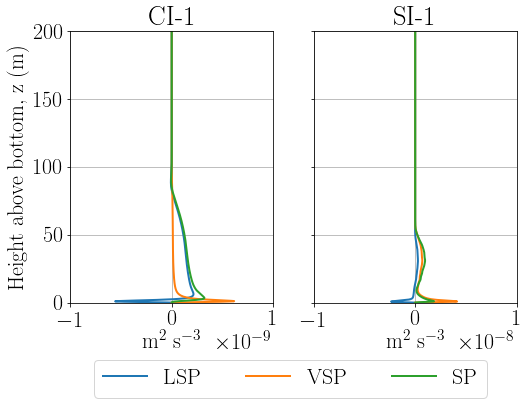

In [173]:
t1 = 9
t2 = 11
t1 = 4
t2 = 6

t1 = 25
t2 = 30
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

plt.figure()
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,5))
ax[0].plot(np.mean(LATSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VERTSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VERTSP_CI[ti_CI,:] + LATSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
#ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_CI) #sanity check that total shear production equals LSP + VSP
ax[0].grid()
ax[0].set_xlim(-5e-9, 5e-9)
ax[0].set_xlim(-1e-9, 1e-9)

ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')

ax[1].plot(np.mean(LATSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='LSP')
ax[1].plot(np.mean(VERTSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='VSP')
ax[1].plot(np.mean(VERTSP_SI[ti_SI,:] + LATSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP')
ax[1].set_xlim(-1e-8, 1e-8)
ax[1].grid()
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')
ax[0].set_ylim(0, 200)
ax[0].set_ylabel('Height above bottom, z (m)')

ax[1].legend(bbox_to_anchor=(-0.115, -0.35), loc='lower center', borderaxespad=0., ncol=3)
if SAVEFLAG:
    plt.savefig(f'./MSFigs/LSPvVSP.pdf', bbox_inches='tight')

In [175]:
## Look at the verticaly integrated LSP vs. VSP ratio compared to S^2

zlower = 10
zl = np.argmin(np.abs(z_CI-zlower))
LATSP_CI_I = integrate.trapz(np.mean(LATSP_CI[ti_CI,zl:], axis=0), x=z_CI[zl:])
VERTSP_CI_I = integrate.trapz(np.mean(VERTSP_CI[ti_CI,zl:], axis=0), x=z_CI[zl:])

print(LATSP_CI_I)
print(VERTSP_CI_I)
print(LATSP_CI_I/VERTSP_CI_I)

zl = np.argmin(np.abs(z_SI-zlower))
LATSP_SI_I = integrate.trapz(np.mean(LATSP_SI[ti_SI,zl:], axis=0), x=z_SI[zl:])
VERTSP_SI_I = integrate.trapz(np.mean(VERTSP_SI[ti_SI,zl:], axis=0), x=z_SI[zl:])

print(LATSP_SI_I)
print(VERTSP_SI_I)
print(LATSP_SI_I/VERTSP_SI_I)

7.928532016333698e-09
1.051234646531617e-09
7.542114448465563
5.6657969143322415e-09
2.090791069176182e-08
0.27098819187919576


In [155]:
f['tasks']['LSPu'][:,0,:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.04807588e-18,  5.90503086e-17,  3.64587433e-16, ...,
        -3.38469235e-21,  2.00965020e-21, -6.41151141e-22],
       [ 2.05699663e-19,  6.21766460e-17,  3.68641978e-16, ...,
         1.39180147e-21, -8.37640485e-22,  2.88527537e-22],
       ...,
       [ 1.14286777e-14,  9.83898906e-13,  6.85962763e-12, ...,
         6.71544806e-17, -3.48469695e-17, -6.40313412e-18],
       [ 1.23503133e-14,  9.40256825e-13,  6.58071161e-12, ...,
        -2.30584574e-17,  1.38940738e-17, -4.93355363e-18],
       [ 1.14511587e-14,  9.04657635e-13,  6.32660497e-12, ...,
         1.00950711e-16, -5.36030212e-17, -1.54820681e-17]])